<table align="left"><tr><td>
<a href="https://colab.research.google.com/github/rickiepark/nlp-with-transformers/blob/main/07_question-answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="코랩에서 실행하기"/></a>
</td></tr></table>

In [1]:
# 코랩이나 캐글을 사용한다면 이 셀의 주석을 제거하고 실행하세요.
# !git clone https://github.com/rickiepark/nlp-with-transformers.git
# %cd nlp-with-transformers
# from install import *
# install_requirements(is_chapter7=True)

In [2]:
from utils import *
setup_chapter()

2022-08-02 02:02:21.098656: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-02 02:02:21.098694: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


No GPU was detected! This notebook can be *very* slow without a GPU 🐢
Using transformers v4.21.0
Using datasets v2.4.0


In [3]:
%env TOKENIZERS_PARALLELISM=false

env: TOKENIZERS_PARALLELISM=false


In [4]:
# haystack의 로깅을 끕니다.
import logging
for module in ["farm.utils", "farm.infer", "haystack.reader.farm.FARMReader",
               "farm.modeling.prediction_head", "elasticsearch", "haystack.eval",
               "haystack.document_store.base", "haystack.retriever.base", 
               "farm.data_handler.dataset"]:
    module_logger = logging.getLogger(module)
    module_logger.setLevel(logging.ERROR)

# 질문 답변

<img alt="Marie Curie" width="500" caption="A Google search query and corresponding answer snippet" src="images/chapter07_marie-curie.png" id="marie-curie"/>

## 리뷰 기반 QA 시스템 구축하기

### 데이터셋

<img alt="Phone with Query" width="400" caption="A question about a product and the corresponding review (the answer span is underlined)" src="images/chapter07_phone.png" id="phone"/>

In [5]:
from datasets import get_dataset_config_names

domains = get_dataset_config_names("subjqa")
domains

['books', 'electronics', 'grocery', 'movies', 'restaurants', 'tripadvisor']

In [6]:
from datasets import load_dataset

subjqa = load_dataset("subjqa", name="electronics")

  0%|          | 0/3 [00:00<?, ?it/s]

In [7]:
print(subjqa["train"]["answers"][1])

{'text': ['Bass is weak as expected', 'Bass is weak as expected, even with EQ
adjusted up'], 'answer_start': [1302, 1302], 'answer_subj_level': [1, 1],
'ans_subj_score': [0.5083333253860474, 0.5083333253860474], 'is_ans_subjective':
[True, True]}


In [8]:
import pandas as pd

dfs = {split: dset.to_pandas() for split, dset in subjqa.flatten().items()}

for split, df in dfs.items():
    print(f"{split}에 있는 질문 개수: {df['id'].nunique()}")

train에 있는 질문 개수: 1295
test에 있는 질문 개수: 358
validation에 있는 질문 개수: 255


In [9]:
qa_cols = ["title", "question", "answers.text", 
           "answers.answer_start", "context"]
sample_df = dfs["train"][qa_cols].sample(2, random_state=7)
sample_df

,title,question,answers.text,answers.answer_start,context
791,B005DKZTMG,Does the keyboard lightweight?,[this keyboard is compact],[215],I really like this keyboard. I give it 4 star...
1159,B00AAIPT76,How is the battery?,[],[],I bought this after the first spare gopro batt...


In [10]:
start_idx = sample_df["answers.answer_start"].iloc[0][0]
end_idx = start_idx + len(sample_df["answers.text"].iloc[0][0])
sample_df["context"].iloc[0][start_idx:end_idx]

'this keyboard is compact'

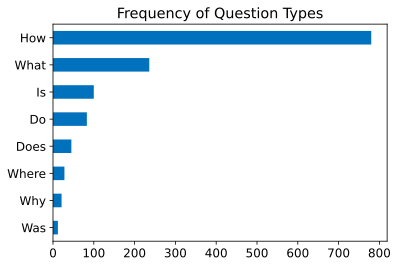

In [11]:
counts = {}
question_types = ["What", "How", "Is", "Does", "Do", "Was", "Where", "Why"]

for q in question_types:
    counts[q] = dfs["train"]["question"].str.startswith(q).value_counts()[True]

pd.Series(counts).sort_values().plot.barh()
plt.title("Frequency of Question Types")
plt.show()

In [12]:
for question_type in ["How", "What", "Is"]:
    for question in (
        dfs["train"][dfs["train"].question.str.startswith(question_type)]
        .sample(n=3, random_state=42)['question']):
        print(question)

How is the camera?
How do you like the control?
How fast is the charger?
What is direction?
What is the quality of the construction of the bag?
What is your impression of the product?
Is this how zoom works?
Is sound clear?
Is it a wireless keyboard?


### 사이드바: 스탠포드 질문 답변 데이터셋

<img alt="SQuAD SotA" width="600" caption="Progress on the SQuAD 2.0 benchmark (image from Papers with Code)" src="images/chapter07_squad-sota.png" id="squad-sota"/>

### 사이드바 끝

### 텍스트에서 답 추출하기

#### 범위 분류

<img alt="QA Head" caption="The span classification head for QA tasks" src="images/chapter07_qa-head.png" id="qa-head"/>

<img alt="SQuAD models" width="600" caption="A selection of extractive QA models on the Hugging Face Hub" src="images/chapter07_squad-models.png" id="squad-models"/> 

#### QA를 위한 텍스트 토큰화

In [13]:
from transformers import AutoTokenizer

model_ckpt = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [14]:
question = "How much music can this hold?"
context = """An MP3 is about 1 MB/minute, so about 6000 hours depending on \
file size."""
inputs = tokenizer(question, context, return_tensors="pt")

In [15]:
input_df = pd.DataFrame.from_dict(tokenizer(question, context), orient="index")
input_df

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
input_ids,101,2129,2172,2189,2064,2023,2907,1029,102,2019,...,2061,2055,25961,2847,5834,2006,5371,2946,1012,102
token_type_ids,0,0,0,0,0,0,0,0,0,1,...,1,1,1,1,1,1,1,1,1,1
attention_mask,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1


In [16]:
print(tokenizer.decode(inputs["input_ids"][0]))

[CLS] how much music can this hold? [SEP] an mp3 is about 1 mb / minute, so
about 6000 hours depending on file size. [SEP]


In [17]:
import torch
from transformers import AutoModelForQuestionAnswering

model = AutoModelForQuestionAnswering.from_pretrained(model_ckpt)

with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

QuestionAnsweringModelOutput(loss=None, start_logits=tensor([[-0.9862, -4.7750,
-5.4025, -5.2378, -5.2863, -5.5117, -4.9819, -6.1880,
         -0.9862,  0.2596, -0.2144, -1.7136,  3.7806,  4.8561, -1.0546, -3.9097,
         -1.7374, -4.5944, -1.4278,  3.9949,  5.0391, -0.2018, -3.0193, -4.8549,
         -2.3107, -3.5110, -3.5713, -0.9862]]), end_logits=tensor([[-0.9623,
-5.4733, -5.0326, -5.1639, -5.4278, -5.5151, -5.1749, -4.6233,
         -0.9623, -3.7855, -0.8715, -3.7745, -3.0161, -1.1780,  0.1758, -2.7365,
          4.8934,  0.3046, -3.1761, -3.2762,  0.8937,  5.6606, -0.3623, -4.9554,
         -3.2531, -0.0914,  1.6211, -0.9623]]), hidden_states=None,
attentions=None)


In [18]:
start_logits = outputs.start_logits
end_logits = outputs.end_logits

In [19]:
print(f"입력 ID 크기: {inputs.input_ids.size()}")
print(f"시작 로짓 크기: {start_logits.size()}")
print(f"종료 로짓 크기: {end_logits.size()}")

입력 ID 크기: torch.Size([1, 28])
시작 로짓 크기: torch.Size([1, 28])
종료 로짓 크기: torch.Size([1, 28])


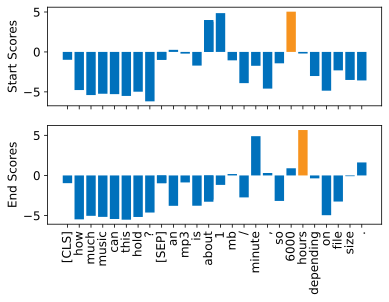

In [20]:
# qa 점수
# 시작 토큰과 종료 토큰에 대한 예측 로짓. 오렌지 색 토큰이 가장 높은 점수를 가진 토큰입니다.
# 이 그래프는 다음을 참고했습니다. https://mccormickml.com/2020/03/10/question-answering-with-a-fine-tuned-BERT
import numpy as np
import matplotlib.pyplot as plt

s_scores = start_logits.detach().numpy().flatten()
e_scores = end_logits.detach().numpy().flatten()
tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True)
colors = ["C0" if s != np.max(s_scores) else "C1" for s in s_scores]
ax1.bar(x=tokens, height=s_scores, color=colors)
ax1.set_ylabel("Start Scores")
colors = ["C0" if s != np.max(e_scores) else "C1" for s in e_scores]
ax2.bar(x=tokens, height=e_scores, color=colors)
ax2.set_ylabel("End Scores")
plt.xticks(rotation="vertical")
plt.show()

In [21]:
import torch 

start_idx = torch.argmax(start_logits)  
end_idx = torch.argmax(end_logits) + 1  
answer_span = inputs["input_ids"][0][start_idx:end_idx]
answer = tokenizer.decode(answer_span)
print(f"질문: {question}")
print(f"답변: {answer}")

질문: How much music can this hold?
답변: 6000 hours


In [22]:
from transformers import pipeline

pipe = pipeline("question-answering", model=model, tokenizer=tokenizer)
pipe(question=question, context=context, topk=3)

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/transformers/pipelines/question_answering.py:189: UserWarning: topk parameter is deprecated, use top_k instead
  warnings.warn("topk parameter is deprecated, use top_k instead", UserWarning)


[{'score': 0.2651609778404236, 'start': 38, 'end': 48, 'answer': '6000 hours'},
 {'score': 0.22082960605621338,
  'start': 16,
  'end': 48,
  'answer': '1 MB/minute, so about 6000 hours'},
 {'score': 0.10253555327653885,
  'start': 16,
  'end': 27,
  'answer': '1 MB/minute'}]

In [23]:
pipe(question="Why is there no data?", context=context, 
     handle_impossible_answer=True)

{'score': 0.9068408608436584, 'start': 0, 'end': 0, 'answer': ''}

#### 긴 텍스트 다루기

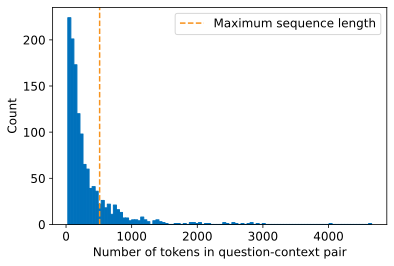

In [24]:
# SubjQA 훈련 세트에 있는 질문-문맥 쌍의 토큰 분포
def compute_input_length(row):
    inputs = tokenizer(row["question"], row["context"])
    return len(inputs["input_ids"])

dfs["train"]["n_tokens"] = dfs["train"].apply(compute_input_length, axis=1)

fig, ax = plt.subplots()
dfs["train"]["n_tokens"].hist(bins=100, grid=False, ec="C0", ax=ax)
plt.xlabel("Number of tokens in question-context pair")
ax.axvline(x=512, ymin=0, ymax=1, linestyle="--", color="C1", 
           label="Maximum sequence length")
plt.legend()
plt.ylabel("Count")
plt.show()

<img alt="Sliding window" caption="How the sliding window creates multiple question-context pairs for long documents—the first bar corresponds to the question, while the second bar is the context captured in each window" src="images/chapter07_sliding-window.png" id="sliding-window"/>

In [25]:
example = dfs["train"].iloc[0][["question", "context"]]
tokenized_example = tokenizer(example["question"], example["context"], 
                              return_overflowing_tokens=True, max_length=100, 
                              stride=25)

In [26]:
for idx, window in enumerate(tokenized_example["input_ids"]):
    print(f"Window #{idx} has {len(window)} tokens")

Window #0 has 100 tokens
Window #1 has 88 tokens


In [27]:
for window in tokenized_example["input_ids"]:
    print(f"{tokenizer.decode(window)} \n")

[CLS] how is the bass? [SEP] i have had koss headphones in the past, pro 4aa and
qz - 99. the koss portapro is portable and has great bass response. the work
great with my android phone and can be " rolled up " to be carried in my
motorcycle jacket or computer bag without getting crunched. they are very light
and don't feel heavy or bear down on your ears even after listening to music
with them on all day. the sound is [SEP]

[CLS] how is the bass? [SEP] and don't feel heavy or bear down on your ears even
after listening to music with them on all day. the sound is night and day better
than any ear - bud could be and are almost as good as the pro 4aa. they are "
open air " headphones so you cannot match the bass to the sealed types, but it
comes close. for $ 32, you cannot go wrong. [SEP]



### 헤이스택을 사용해 QA 파이프라인 구축하기

<img alt="QA Architecture" caption="The retriever-reader architecture for modern QA systems" src="images/chapter07_retriever-reader.png" id="retriever-reader"/>

#### Initializing a document store

In [32]:
url = """https://artifacts.elastic.co/downloads/elasticsearch/\
elasticsearch-7.9.2-linux-x86_64.tar.gz"""
!wget -nc -q {url}
!tar -xzf elasticsearch-7.9.2-linux-x86_64.tar.gz

In [34]:
import os
from subprocess import Popen, PIPE, STDOUT

# Run Elasticsearch as a background process
!chown -R daemon:daemon elasticsearch-7.9.2
es_server = Popen(args=['elasticsearch-7.9.2/bin/elasticsearch'],
                  stdout=PIPE, stderr=STDOUT, preexec_fn=lambda: os.setuid(1))
# Wait until Elasticsearch has started
!sleep 30

SubprocessError: Exception occurred in preexec_fn.

In [ ]:
# Alternative if Docker is installed
from haystack.utils import launch_es

launch_es()

In [ ]:
!curl -X GET "localhost:9200/?pretty"

{
  "name" : "96938eee37cd",
  "cluster_name" : "docker-cluster",
  "cluster_uuid" : "ABGDdvbbRWmMb9Umz79HbA",
  "version" : {
    "number" : "7.9.2",
    "build_flavor" : "default",
    "build_type" : "docker",
    "build_hash" : "d34da0ea4a966c4e49417f2da2f244e3e97b4e6e",
    "build_date" : "2020-09-23T00:45:33.626720Z",
    "build_snapshot" : false,
    "lucene_version" : "8.6.2",
    "minimum_wire_compatibility_version" : "6.8.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [ ]:
from haystack.document_store.elasticsearch import ElasticsearchDocumentStore

# Return the document embedding for later use with dense retriever 
document_store = ElasticsearchDocumentStore(return_embedding=True)

In [ ]:
# It's a good idea to flush Elasticsearch with each notebook restart
if len(document_store.get_all_documents()) or len(document_store.get_all_labels()) > 0:
    document_store.delete_documents("document")
    document_store.delete_documents("label")

In [ ]:
for split, df in dfs.items():
    # Exclude duplicate reviews
    docs = [{"text": row["context"], 
             "meta":{"item_id": row["title"], "question_id": row["id"], 
                     "split": split}} 
        for _,row in df.drop_duplicates(subset="context").iterrows()]
    document_store.write_documents(docs, index="document")
    
print(f"Loaded {document_store.get_document_count()} documents")

Loaded 1615 documents


#### Initializing a retriever

In [ ]:
from haystack.retriever.sparse import ElasticsearchRetriever

es_retriever = ElasticsearchRetriever(document_store=document_store)

In [ ]:
item_id = "B0074BW614"
query = "Is it good for reading?"
retrieved_docs = es_retriever.retrieve(
    query=query, top_k=3, filters={"item_id":[item_id], "split":["train"]})

In [ ]:
print(retrieved_docs[0])

{'text': 'This is a gift to myself.  I have been a kindle user for 4 years and
this is my third one.  I never thought I would want a fire for I mainly use it
for book reading.  I decided to try the fire for when I travel I take my laptop,
my phone and my iPod classic.  I love my iPod but watching movies on the plane
with it can be challenging because it is so small. Laptops battery life is not
as good as the Kindle.  So the Fire combines for me what I needed all three to
do. So far so good.', 'score': 6.243799, 'probability': 0.6857824513476455,
'question': None, 'meta': {'item_id': 'B0074BW614', 'question_id':
'868e311275e26dbafe5af70774a300f3', 'split': 'train'}, 'embedding': None, 'id':
'252e83e25d52df7311d597dc89eef9f6'}


#### Initializing a reader

In [ ]:
from haystack.reader.farm import FARMReader

model_ckpt = "deepset/minilm-uncased-squad2"
max_seq_length, doc_stride = 384, 128
reader = FARMReader(model_name_or_path=model_ckpt, progress_bar=False,
                    max_seq_len=max_seq_length, doc_stride=doc_stride, 
                    return_no_answer=True)

10/27/2021 20:34:28 - INFO - farm.utils -   Using device: CUDA 
10/27/2021 20:34:28 - INFO - farm.utils -   Number of GPUs: 1
10/27/2021 20:34:28 - INFO - farm.utils -   Distributed Training: False
10/27/2021 20:34:28 - INFO - farm.utils -   Automatic Mixed Precision: None
Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertModel: ['qa_outputs.weight', 'qa_outputs.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
10/27/2021 20:34:43 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be lo

In [ ]:
print(reader.predict_on_texts(question=question, texts=[context], top_k=1))

{'query': 'How much music can this hold?', 'no_ans_gap': 12.648084878921509,
'answers': [{'answer': '6000 hours', 'score': 10.69961929321289, 'probability':
0.3988136053085327, 'context': 'An MP3 is about 1 MB/minute, so about 6000 hours
depending on file size.', 'offset_start': 38, 'offset_end': 48,
'offset_start_in_doc': 38, 'offset_end_in_doc': 48, 'document_id':
'e344757014e804eff50faa3ecf1c9c75'}]}


#### Putting it all together

In [ ]:
from haystack.pipeline import ExtractiveQAPipeline

pipe = ExtractiveQAPipeline(reader, es_retriever)

In [ ]:
n_answers = 3
preds = pipe.run(query=query, top_k_retriever=3, top_k_reader=n_answers,
                 filters={"item_id": [item_id], "split":["train"]})

print(f"Question: {preds['query']} \n")
for idx in range(n_answers):
    print(f"Answer {idx+1}: {preds['answers'][idx]['answer']}")
    print(f"Review snippet: ...{preds['answers'][idx]['context']}...")
    print("\n\n")

Question: Is it good for reading?

Answer 1: I mainly use it for book reading
Review snippet: ... is my third one.  I never thought I would want a fire for I
mainly use it for book reading.  I decided to try the fire for when I travel I
take my la...



Answer 2: the larger screen compared to the Kindle makes for easier reading
Review snippet: ...ght enough that I can hold it to read, but the larger screen
compared to the Kindle makes for easier reading. I love the color, something I
never thou...



Answer 3: it is great for reading books when no light is available
Review snippet: ...ecoming addicted to hers! Our son LOVES it and it is great
for reading books when no light is available. Amazing sound but I suggest good
headphones t...





## Improving Our QA Pipeline

### Evaluating the Retriever

In [ ]:
from haystack.pipeline import Pipeline
from haystack.eval import EvalDocuments

class EvalRetrieverPipeline:
    def __init__(self, retriever):
        self.retriever = retriever
        self.eval_retriever = EvalDocuments()
        pipe = Pipeline()
        pipe.add_node(component=self.retriever, name="ESRetriever", 
                      inputs=["Query"])
        pipe.add_node(component=self.eval_retriever, name="EvalRetriever", 
                      inputs=["ESRetriever"])
        self.pipeline = pipe


pipe = EvalRetrieverPipeline(es_retriever)

In [ ]:
from haystack import Label

labels = []
for i, row in dfs["test"].iterrows():
    # Metadata used for filtering in the Retriever
    meta = {"item_id": row["title"], "question_id": row["id"]}
    # Populate labels for questions with answers
    if len(row["answers.text"]):
        for answer in row["answers.text"]:
            label = Label(
                question=row["question"], answer=answer, id=i, origin=row["id"],
                meta=meta, is_correct_answer=True, is_correct_document=True,
                no_answer=False)
            labels.append(label)
    # Populate labels for questions without answers
    else:
        label = Label(
            question=row["question"], answer="", id=i, origin=row["id"],
            meta=meta, is_correct_answer=True, is_correct_document=True,
            no_answer=True)  
        labels.append(label)

In [ ]:
print(labels[0])

{'id': 'e28f5e62-85e8-41b2-8a34-fbff63b7a466', 'created_at': None, 'updated_at':
None, 'question': 'What is the tonal balance of these headphones?', 'answer': 'I
have been a headphone fanatic for thirty years', 'is_correct_answer': True,
'is_correct_document': True, 'origin': 'd0781d13200014aa25860e44da9d5ea7',
'document_id': None, 'offset_start_in_doc': None, 'no_answer': False,
'model_id': None, 'meta': {'item_id': 'B00001WRSJ', 'question_id':
'd0781d13200014aa25860e44da9d5ea7'}}


In [ ]:
document_store.write_labels(labels, index="label")
print(f"""Loaded {document_store.get_label_count(index="label")} \
question-answer pairs""")

Loaded 358 question-answer pairs


In [ ]:
labels_agg = document_store.get_all_labels_aggregated(
    index="label",
    open_domain=True,
    aggregate_by_meta=["item_id"]
)
print(len(labels_agg))

330


In [ ]:
print(labels_agg[109])

{'question': 'How does the fan work?', 'multiple_answers': ['the fan is really
really good', "the fan itself isn't super loud. There is an adjustable dial to
change fan speed"], 'is_correct_answer': True, 'is_correct_document': True,
'origin': '5a9b7616541f700f103d21f8ad41bc4b', 'multiple_document_ids': [None,
None], 'multiple_offset_start_in_docs': [None, None], 'no_answer': False,
'model_id': None, 'meta': {'item_id': 'B002MU1ZRS'}}


In [ ]:
def run_pipeline(pipeline, top_k_retriever=10, top_k_reader=4):
    for l in labels_agg:
        _ = pipeline.pipeline.run(
            query=l.question,
            top_k_retriever=top_k_retriever,
            top_k_reader=top_k_reader,
            top_k_eval_documents=top_k_retriever,    
            labels=l,
            filters={"item_id": [l.meta["item_id"]], "split": ["test"]})

In [ ]:
run_pipeline(pipe, top_k_retriever=3)
print(f"Recall@3: {pipe.eval_retriever.recall:.2f}")

Recall@3: 0.95


In [ ]:
def evaluate_retriever(retriever, topk_values = [1,3,5,10,20]):
    topk_results = {}

    for topk in topk_values:
        # Create Pipeline
        p = EvalRetrieverPipeline(retriever)
        # Loop over each question-answers pair in test set
        run_pipeline(p, top_k_retriever=topk)
        # Get metrics
        topk_results[topk] = {"recall": p.eval_retriever.recall}
        
    return pd.DataFrame.from_dict(topk_results, orient="index")


es_topk_df = evaluate_retriever(es_retriever)

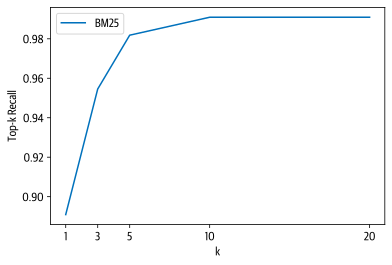

In [ ]:
def plot_retriever_eval(dfs, retriever_names):
    fig, ax = plt.subplots()
    for df, retriever_name in zip(dfs, retriever_names):
        df.plot(y="recall", ax=ax, label=retriever_name)
    plt.xticks(df.index)
    plt.ylabel("Top-k Recall")
    plt.xlabel("k")
    plt.show()
    
plot_retriever_eval([es_topk_df], ["BM25"])

#### Dense Passage Retrieval

<img alt="DPR Architecture" caption="DPR's bi-encoder architecture for computing the relevance of a document and query" src="images/chapter07_dpr.png" id="dpr"/>

In [ ]:
from haystack.retriever.dense import DensePassageRetriever

dpr_retriever = DensePassageRetriever(document_store=document_store,
    query_embedding_model="facebook/dpr-question_encoder-single-nq-base",
    passage_embedding_model="facebook/dpr-ctx_encoder-single-nq-base",
    embed_title=False)

In [ ]:
document_store.update_embeddings(retriever=dpr_retriever)

10/27/2021 20:45:58 - INFO - haystack.document_store.elasticsearch -   Updating embeddings for all 1615 docs ...


Updating embeddings:   0%|          | 0/1615 [00:00<?, ? Docs/s]

Create embeddings:   0%|          | 0/1616 [00:00<?, ? Docs/s]

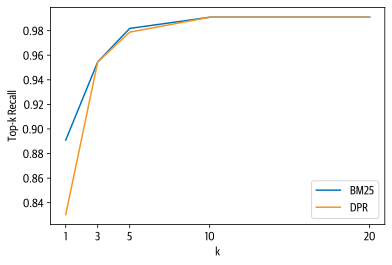

In [ ]:
dpr_topk_df = evaluate_retriever(dpr_retriever)
plot_retriever_eval([es_topk_df, dpr_topk_df], ["BM25", "DPR"])

### Evaluating the Reader

In [ ]:
from farm.evaluation.squad_evaluation import compute_f1, compute_exact

pred = "about 6000 hours"
label = "6000 hours"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.8


In [ ]:
pred = "about 6000 dollars"
print(f"EM: {compute_exact(label, pred)}")
print(f"F1: {compute_f1(label, pred)}")

EM: 0
F1: 0.4


In [ ]:
from haystack.eval import EvalAnswers

def evaluate_reader(reader):
    score_keys = ['top_1_em', 'top_1_f1']
    eval_reader = EvalAnswers(skip_incorrect_retrieval=False)
    pipe = Pipeline()
    pipe.add_node(component=reader, name="QAReader", inputs=["Query"])
    pipe.add_node(component=eval_reader, name="EvalReader", inputs=["QAReader"])

    for l in labels_agg:
        doc = document_store.query(l.question, 
                                   filters={"question_id":[l.origin]})
        _ = pipe.run(query=l.question, documents=doc, labels=l)
                
    return {k:v for k,v in eval_reader.__dict__.items() if k in score_keys}

reader_eval = {}
reader_eval["Fine-tune on SQuAD"] = evaluate_reader(reader)

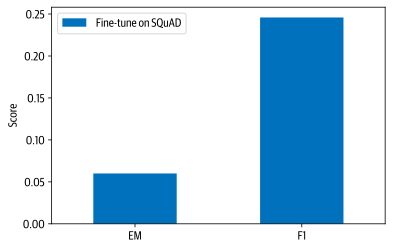

In [ ]:
def plot_reader_eval(reader_eval):
    fig, ax = plt.subplots()
    df = pd.DataFrame.from_dict(reader_eval)
    df.plot(kind="bar", ylabel="Score", rot=0, ax=ax)
    ax.set_xticklabels(["EM", "F1"])
    plt.legend(loc='upper left')
    plt.show()

plot_reader_eval(reader_eval)

### Domain Adaptation

<img alt="SQuAD Schema" caption="Visualization of the SQuAD JSON format" src="images/chapter07_squad-schema.png" id="squad-schema"/>

In [ ]:
def create_paragraphs(df):
    paragraphs = []
    id2context = dict(zip(df["review_id"], df["context"]))
    for review_id, review in id2context.items():
        qas = []
        # Filter for all question-answer pairs about a specific context
        review_df = df.query(f"review_id == '{review_id}'")
        id2question = dict(zip(review_df["id"], review_df["question"]))
        # Build up the qas array
        for qid, question in id2question.items():
            # Filter for a single question ID
            question_df = df.query(f"id == '{qid}'").to_dict(orient="list")
            ans_start_idxs = question_df["answers.answer_start"][0].tolist()
            ans_text = question_df["answers.text"][0].tolist()
            # Fill answerable questions
            if len(ans_start_idxs):
                answers = [
                    {"text": text, "answer_start": answer_start}
                    for text, answer_start in zip(ans_text, ans_start_idxs)]
                is_impossible = False
            else:
                answers = []
                is_impossible = True
            # Add question-answer pairs to qas
            qas.append({"question": question, "id": qid, 
                        "is_impossible": is_impossible, "answers": answers})
        # Add context and question-answer pairs to paragraphs
        paragraphs.append({"qas": qas, "context": review})
    return paragraphs

In [ ]:
product = dfs["train"].query("title == 'B00001P4ZH'")
create_paragraphs(product)

[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones in the past, Pro 4AA and QZ-99.  The Koss Portapro is portable AND has great bass response.  The work great with my Android phone and can be "rolled up" to be carried in my motorcycle jacket or computer bag without getting crunched.  They are very light and do not feel heavy or bear down on your ears even after listening to music with them on all day.  The sound is night and day better than any ear-bud could be and are almost as good as the Pro 4AA.  They are "open air" headphones so you cannot match the bass to the sealed types, but it comes close. For $32, you cannot go wrong.'},
 {'qas': [{'question': 'Is this music song have a goo bass?',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass i

```python
[{'qas': [{'question': 'How is the bass?',
    'id': '2543d296da9766d8d17d040ecc781699',
    'is_impossible': True,
    'answers': []}],
  'context': 'I have had Koss headphones ...',
    'id': 'd476830bf9282e2b9033e2bb44bbb995',
    'is_impossible': False,
    'answers': [{'text': 'Bass is weak as expected', 'answer_start': 1302},
     {'text': 'Bass is weak as expected, even with EQ adjusted up',
      'answer_start': 1302}]}],
  'context': 'To anyone who hasn\'t tried all ...'},
 {'qas': [{'question': 'How is the bass?',
    'id': '455575557886d6dfeea5aa19577e5de4',
    'is_impossible': False,
    'answers': [{'text': 'The only fault in the sound is the bass',
      'answer_start': 650}]}],
  'context': "I have had many sub-$100 headphones ..."}]
```

In [ ]:
import json

def convert_to_squad(dfs):
    for split, df in dfs.items():
        subjqa_data = {}
        # Create `paragraphs` for each product ID
        groups = (df.groupby("title").apply(create_paragraphs)
            .to_frame(name="paragraphs").reset_index())
        subjqa_data["data"] = groups.to_dict(orient="records")
        # Save the result to disk
        with open(f"electronics-{split}.json", "w+", encoding="utf-8") as f:
            json.dump(subjqa_data, f)
            
convert_to_squad(dfs)

In [ ]:
train_filename = "electronics-train.json"
dev_filename = "electronics-validation.json"

reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

10/27/2021 20:47:36 - INFO - farm.utils -   Using device: CUDA 
10/27/2021 20:47:36 - INFO - farm.utils -   Number of GPUs: 1
10/27/2021 20:47:36 - INFO - farm.utils -   Distributed Training: False
10/27/2021 20:47:36 - INFO - farm.utils -   Automatic Mixed Precision: None
Preprocessing Dataset electronics-train.json:   6%|███▏                                                   | 72/1265 [00:00<00:06, 194.71 Dicts/s]10/27/2021 20:47:39 - WARNING - farm.data_handler.processor -   Answer using start/end indices is '  Operation of the menus and contro' while gold label text is 'Operation of the menus and controls'.
Example will not be converted for training/evaluation.
10/27/2021 20:47:39 - WARNING - farm.data_handler.processor -   Answer using start/end indices is '  This camera performs like the pros.  Fast accurate and easy to operat' while gold label text is 'This camera performs like the pros.  Fast accurate and easy to operated'.
Example will not be converted for training/evaluation.

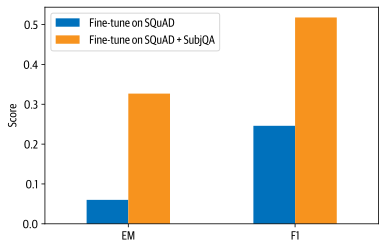

In [ ]:
reader_eval["Fine-tune on SQuAD + SubjQA"] = evaluate_reader(reader)
plot_reader_eval(reader_eval)

In [ ]:
minilm_ckpt = "microsoft/MiniLM-L12-H384-uncased"
minilm_reader = FARMReader(model_name_or_path=minilm_ckpt, progress_bar=False,
                           max_seq_len=max_seq_length, doc_stride=doc_stride,
                           return_no_answer=True)

10/27/2021 20:48:42 - INFO - farm.utils -   Using device: CUDA 
10/27/2021 20:48:42 - INFO - farm.utils -   Number of GPUs: 1
10/27/2021 20:48:42 - INFO - farm.utils -   Distributed Training: False
10/27/2021 20:48:42 - INFO - farm.utils -   Automatic Mixed Precision: None
Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at microsoft/MiniLM-L12-H384-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
10/27/2021 20:48:46 - WARNING - farm.utils -   ML Logging is turned off. No parameters, metrics or artifacts will be logged to MLFlow.
10/27/2021 20:48:46 - INFO - farm.utils -   Using device: CUDA 
10/27/2021 20:48:46 - INFO - farm.utils -   Number of GPUs: 1
10/27/2021 20:48:46 - INFO - farm.utils -   Distributed Training: False
10/27/2021 20:48:46 - INFO - farm.utils -   Automatic Mixed Precision: None
10/27/2021 20

In [ ]:
minilm_reader.train(data_dir=".", use_gpu=True, n_epochs=1, batch_size=16,
             train_filename=train_filename, dev_filename=dev_filename)

10/27/2021 20:48:49 - INFO - farm.utils -   Using device: CUDA 
10/27/2021 20:48:49 - INFO - farm.utils -   Number of GPUs: 1
10/27/2021 20:48:49 - INFO - farm.utils -   Distributed Training: False
10/27/2021 20:48:49 - INFO - farm.utils -   Automatic Mixed Precision: None
Preprocessing Dataset electronics-train.json:   6%|███▏                                                   | 72/1265 [00:00<00:04, 246.81 Dicts/s]10/27/2021 20:48:51 - WARNING - farm.data_handler.processor -   Answer using start/end indices is '  Operation of the menus and contro' while gold label text is 'Operation of the menus and controls'.
Example will not be converted for training/evaluation.
10/27/2021 20:48:51 - WARNING - farm.data_handler.processor -   Answer using start/end indices is '  This camera performs like the pros.  Fast accurate and easy to operat' while gold label text is 'This camera performs like the pros.  Fast accurate and easy to operated'.
Example will not be converted for training/evaluation.

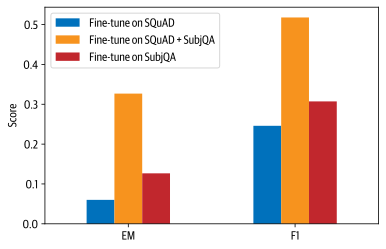

In [ ]:
reader_eval["Fine-tune on SubjQA"] = evaluate_reader(minilm_reader)
plot_reader_eval(reader_eval)

### Evaluating the Whole QA Pipeline

In [ ]:
# Initialize retriever pipeline
pipe = EvalRetrieverPipeline(es_retriever)
# Add nodes for reader
eval_reader = EvalAnswers()
pipe.pipeline.add_node(component=reader, name="QAReader", 
              inputs=["EvalRetriever"])
pipe.pipeline.add_node(component=eval_reader, name="EvalReader", 
              inputs=["QAReader"])
# Evaluate!
run_pipeline(pipe)
# Extract metrics from reader
reader_eval["QA Pipeline (top-1)"] = {
    k:v for k,v in eval_reader.__dict__.items()
    if k in ["top_1_em", "top_1_f1"]}

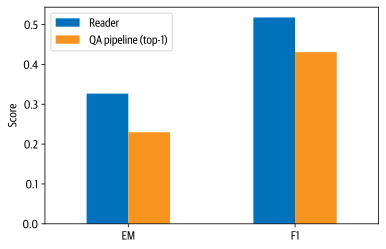

In [ ]:
#id reader-vs-pipeline
#caption Comparison of EM and _F_~1~ scores for the reader against the whole QA pipeline
plot_reader_eval({"Reader": reader_eval["Fine-tune on SQuAD + SubjQA"], 
                  "QA pipeline (top-1)": reader_eval["QA Pipeline (top-1)"]})

## Going Beyond Extractive QA

<img alt="RAG Architecture" width="600" caption="The RAG architecture for fine-tuning a retriever and generator end-to-end (courtesy of Ethan Perez)" src="images/chapter07_rag-architecture.png" id="rag"/>

In [ ]:
from haystack.generator.transformers import RAGenerator

generator = RAGenerator(model_name_or_path="facebook/rag-token-nq",
                        embed_title=False, num_beams=5)

/home/lewis/miniconda3/envs/book-qa/lib/python3.7/site-packages/transformers/models/bart/configuration_bart.py:178: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions.The config can simply be saved and uploaded again to be fixed.
  f"Please make sure the config includes `forced_bos_token_id={self.bos_token_id}` in future versions."
Some weights of RagTokenForGeneration were not initialized from the model checkpoint at facebook/rag-token-nq and are newly initialized: ['rag.generator.lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from haystack.pipeline import GenerativeQAPipeline

pipe = GenerativeQAPipeline(generator=generator, retriever=dpr_retriever)

In [ ]:
def generate_answers(query, top_k_generator=3):
    preds = pipe.run(query=query, top_k_generator=top_k_generator, 
                     top_k_retriever=5, filters={"item_id":["B0074BW614"]})  
    print(f"Question: {preds['query']} \n")
    for idx in range(top_k_generator):
        print(f"Answer {idx+1}: {preds['answers'][idx]['answer']}")

In [ ]:
generate_answers(query)

Question: Is it good for reading?

Answer 1:  the screen is absolutely beautiful
Answer 2:  the Screen is absolutely beautiful
Answer 3:  Kindle fire


In [ ]:
generate_answers("What is the main drawback?")

Question: What is the main drawback?

Answer 1:  the price
Answer 2:  no flash support
Answer 3:  the cost


## Conclusion

<img alt="QA Pyramid" caption="The QA hierarchy of needs" src="images/chapter07_qa-pyramid.png" id="qa-pyramid"/> 